**Kovasznay flow**

Re-typed by Theodoret Putra Agatho on 25 Okt. 2023

[Source](https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/Kovasznay.flow.html)

In [ ]:
pip install deepxde

**Problem setup**

We will solve the Kovasznay flow equation on $\Omega = [0, 1]^2.$.

\begin{align}
        u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = - \frac{\partial p}{\partial x} + \frac{1}{Re} (\frac{\partial ^2 u}{\partial x^2} + \frac{\partial ^2 u}{\partial y^2}),
        \newline
        u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} = - \frac{\partial p}{\partial y} + \frac{1}{Re} (\frac{\partial ^2 v}{\partial x^2} + \frac{\partial ^2 v}{\partial y^2}),
    \end{align}

with the Dirichlet boundary conditions

\begin{align}
        u(x, y) = 0, (x, y) \in \partial \Omega
    \end{align}

The reference solution is $u = 1 - e^{\lambda x} \cos (2 \pi y), v = \frac{\lambda}{2 \pi} e^{\lambda x} \sin (2 \pi x), p = \frac{1}{2} (1 - e^{2 \lambda x})$, where $\lambda = \frac{1}{2 \nu} - \sqrt{\frac{1}{4 \nu ^2} + 4 \pi ^2}$.

**Implementation**

This description goes throught the implementation of a solver for the above described Kovasznay flow step-by-step.

First, the DeepXDE and Numpy modules are imported:

In [ ]:
import deepxde as dde
import numpy as np

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


We begin by defining the parameters of the equation. $\lambda$ is defined as $l$ below:

In [ ]:
Re = 20
nu = 1 / Re
l = 1 / (2 * nu) - np.sqrt(1 / (4 * nu ** 2) + 4 * np.pi ** 2)

Next, we express the PDE residual of the Kovasznay flow equation in terms of the $x$-direction, $y$-direction, and continuity equations.

In [ ]:
def pde(x, u):
  u_vel, v_vel, p = u[:, 0:1], u[:, 1:2], u[:, 2:]
  u_vel_x = dde.grad.jacobian(u, x, i=0, j=0)
  u_vel_y = dde.grad.jacobian(u, x, i=0, j=1)
  u_vel_xx = dde.grad.hessian(u, x, component=0, i=0, j=0)
  u_vel_yy = dde.grad.hessian(u, x, component=0, i=1, j=1)

  v_vel_x = dde.grad.jacobian(u, x, i=1, j=0)
  v_vel_y = dde.grad.jacobian(u, x, i=1, j=1)
  v_vel_xx = dde.grad.hessian(u, x, component=1, i=0, j=0)
  v_vel_yy = dde.grad.hessian(u, x, component=1, i=1, j=1)

  p_x = dde.grad.jacobian(u, x, i=2, j=0)
  p_y = dde.grad.jacobian(u, x, i=2, j=1)

  momentum_x = (
      u_vel * u_vel_x + v_vel * u_vel_y + p_x - 1 / Re * (u_vel_xx + u_vel_yy)
  )
  momentum_y = (
      u_vel * v_vel_x + v_vel * v_vel_y + p_y - 1 / Re * (v_vel_xx + v_vel_yy)
  )
  continuity = u_vel_x + v_vel_y

  return [momentum_x, momentum_y, continuity]

The first argument to `pde` is the network input, *i.e.*, the $x$ and $y$ coordinates. The second argument is the network output `u` which is comprised of the 3 different output solutions, *i.e.*, velocity $u$, velocity $v$, and pressure $p$.

Next, the exact solution of the Kovasznay flow is introduced

In [ ]:
def u_func(x):
  return 1 - np.exp(l * x[:, 0:1]) * np.cos(2 * np.pi * x[:, 1:2])

def v_func(x):
  return l / (2 * np.pi) * np.exp(l * x[:, 0:1]) * np.sin(2 * np.pi * x[:, 1:2])

def p_func(x):
  return 1 / 2 * (1 - np.exp(2 * l * x[:, 0:1]))

Next, we consider the boundary condition. `on_boundary` is chosen here to use the whole boundary of the computational domain as the boundary condition. We include `on_boundary` as the BCs in the `DirichletBC` function of DeepXDE.

In [ ]:
def boundary_outflow(x, on_boundary):
  return on_boundary and dde.utils.isclose(x[0], 1)

spatial_domain = dde.geometry.Rectangle(xmin=[-0.5, -0.5], xmax=[1, 1.5])

boundary_condition_u = dde.icbc.DirichletBC(
    spatial_domain, u_func, lambda _, on_boundary: on_boundary, component=0
)
boundary_condition_v = dde.icbc.DirichletBC(
    spatial_domain, v_func, lambda _, on_boundary: on_boundary, component=1
)
boundary_condition_right_p = dde.icbc.DirichletBC(
    spatial_domain, p_func, boundary_outflow, component=2
)

Now, we have specified the geometry, PDE residual, and boundary condition. We then define the `PDE` problem as

In [ ]:
data = dde.data.PDE(
    spatial_domain,
    pde,
    [boundary_condition_u, boundary_condition_v, boundary_condition_right_p],
    num_domain=2601,
    num_boundary=400,
    num_test=100000,
)

The training residual points inside the domain is 2601, and the number of training points sampled on the boundary is 400. 100000 test points were used in the `PDE`.

Next, we choose the network. We use a fully connected neural network of 4 hidden layers, 3 outputs, and width 50.

In [ ]:
net = dde.nn.FNN([2] + 4 * [50] + [3], "tanh", 'Glorot normal')

The PDE and the network have now been defined. Next, we build a `Model` and choose the optimizer and learning rate.

In [ ]:
model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
model.train(iterations=10000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
Building feed-forward neural network...
'build' took 0.144489 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.031684 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [8.89e-02, 5.19e-02, 2.66e-01, 2.77e+00, 9.27e-02, 1.77e-01]    [9.25e-02, 5.30e-02, 2.73e-01, 2.77e+00, 9.27e-02, 1.77e-01]    []  
1000      [1.51e-02, 6.45e-03, 6.07e-03, 5.19e-02, 2.35e-02, 3.02e-04]    [1.08e-02, 4.63e-03, 4.88e-03, 5.19e-02, 2.35e-02, 3.02e-04]    []  
2000      [5.20e-03, 3.23e-03, 3.32e-03, 1.61e-02, 6.28e-03, 4.10e-04]    [3.02e-03, 2.33e-03, 2.45e-03, 1.61e-02, 6.28e-03, 4.10e-04]    []  
3000      [2.66e-03, 1.67e-03, 1.75e-03, 7.05e-03, 2.83e-03, 3.04e-04]    [1.39e-03, 1.16e-03, 1.37e-03, 7.05e-03, 2.83e-03, 3.04e-04]    []  
4000      [5.79e-03, 1.05e-03, 1.07e-03, 3.66e-03, 1.92e-03, 2.38e-04]    [4.46e-03, 8.72e-04, 9.03e-04, 3.66e-03, 1.92e-03, 2.38e-04]    []  
5000      [3.81e-03, 5.99e-04, 6.89e-04, 1.97e-03, 1.08e-03, 1.37e-04]    [2.81e-03, 4.82

We the train the model for 30000 iterations. After we train the network using `Adam`, we continue to train the network using L-BFGS to achieve a smaller loss.

The next step is to define a spatial domain with the same number of random points 100000 and use the model created to predict the output.

In [ ]:
X = spatial_domain.random_points(100000)
output = model.predict(X)
u_pred = output[:, 0]
v_pred = output[:, 1]
p_pred = output[:, 2]

In [ ]:
u_exact = u_func(X).reshape(-1)
v_exact = v_func(X).reshape(-1)
p_exact = p_func(X).reshape(-1)

Next, we compare the predicted output to the exact output and calculate the loss.

In [ ]:
f = model.predict(X, operator=pde)

l2_difference_u = dde.metrics.l2_relative_error(u_exact, u_pred)
l2_difference_v = dde.metrics.l2_relative_error(v_exact, v_pred)
l2_difference_p = dde.metrics.l2_relative_error(p_exact, p_pred)
residual = np.mean(np.absolute(f))

print("Mean residual:", residual)
print("L2 relative error in u:", l2_difference_u)
print("L2 relative error in v:", l2_difference_v)
print("L2 relative error in p:", l2_difference_p)

Mean residual: 0.00084187114
L2 relative error in u: 0.00033986653
L2 relative error in v: 0.0012332306
L2 relative error in p: 0.0005893126


Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


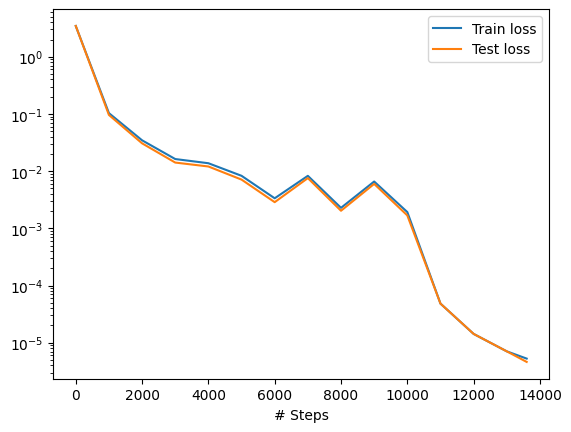

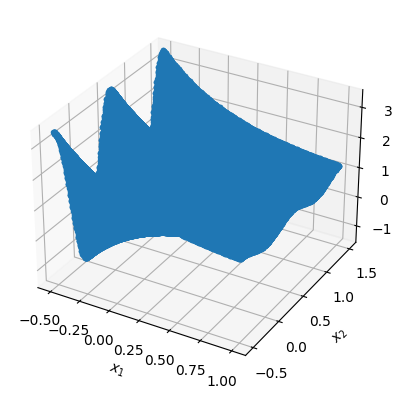

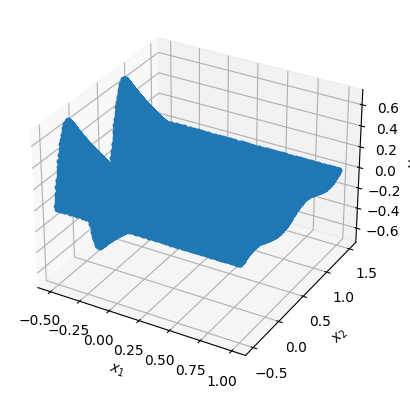

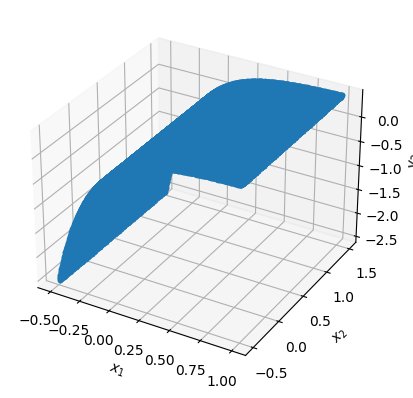

In [ ]:
# Plot the results
dde.saveplot(losshistory, train_state, issave=True, isplot=True)